In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression

In [48]:
# random effects

n_samples = 100
n_effective_groups = 5
make_kwargs_random = dict(n_features=1, noise=10)

n_samples_per_effective_group = np.array(
    [n_samples // n_effective_groups] * n_effective_groups)
rest = n_samples - sum(n_samples_per_effective_group)
n_samples_per_effective_group[:rest] += 1

data = [
    make_regression(n_samples=n, **make_kwargs_random) 
    for n in n_samples_per_effective_group]

X_random = np.concatenate([X for X, y in data])
y_random = np.concatenate([y for X, y in data])

effective_groups = \
    np.repeat(np.arange(n_effective_groups), n_samples_per_effective_group) 

In [49]:
# # visible groups

# n_visible_groups = 10
# n_visible_groups_per_effective_group = \
#     np.array([n_visible_groups // n_effective_groups] * n_effective_groups)
# rest = n_visible_groups - sum(n_visible_groups_per_effective_group)
# n_visible_groups_per_effective_group[:rest] += 1

# visible_groups = np.concatenate([


In [50]:
# fixed effect

make_kwargs_fixed = dict(n_features=1, noise=10)
make_kwargs_fixed = None

if make_kwargs_fixed is None:
    X_fixed, y_fixed = np.zeros_like(X_random), np.zeros_like(y_random)
else:
    X_fixed, y_fixed = make_regression(n_samples=n_samples, **make_kwargs_fixed)

In [51]:
# combined data

X = X_random + X_fixed
y = y_random + y_fixed

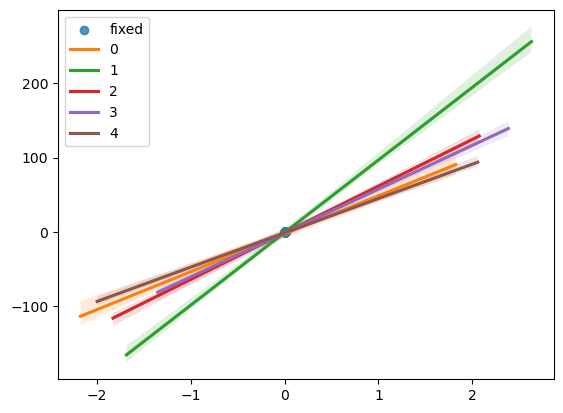

In [57]:
sns.regplot(x=X_fixed, y=y_fixed, label="fixed")
for g in np.unique(effective_groups):
    sns.regplot(x=X[effective_groups == g], y=y[effective_groups == g], scatter=False, label=g)
plt.legend()

In [53]:
from statsmodels.regression.mixed_linear_model import MixedLM
model = MixedLM(y, X, effective_groups, exog_re=X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: y        
No. Observations: 100     Method:             REML     
No. Groups:       5       Scale:              118.3712 
Min. group size:  20      Log-Likelihood:     -388.0052
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
              Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
x1            63.179    9.037 6.991 0.000 45.467 80.892
x_re1 Var    403.344   27.125                          
=======================================================

"""

In [54]:
result.random_effects

{0: x_re1   -12.024816
 dtype: float64,
 1: x_re1    33.885505
 dtype: float64,
 2: x_re1   -0.592696
 dtype: float64,
 3: x_re1   -4.537536
 dtype: float64,
 4: x_re1   -16.730456
 dtype: float64}

In [39]:
result.random_effects_cov

{0:           x_re1
 x_re1  6.156211,
 1:           x_re1
 x_re1  5.336248,
 2:           x_re1
 x_re1  5.428661,
 3:           x_re1
 x_re1  4.651627,
 4:           x_re1
 x_re1  4.475396}